<a href="https://colab.research.google.com/github/jameskch-collab/LLM_Project_Assignment/blob/main/Coffee_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- 1. Data Loading & Cleaning ---
--- 2. Feature Engineering ---
--- 3. Insight Extraction ---
Total Revenue: $698,812.33
Avg Transaction: $4.69
Afternoon Slump Ratio: 53.66%
--- 4. Modelling (Random Forest) ---
R-Squared Score: 0.4509
Mean Absolute Error: $106.98
--- 5. Visualizations ---
--- 6. SHAP Analysis ---
Analysis Complete. Visualizations saved as PNG files.


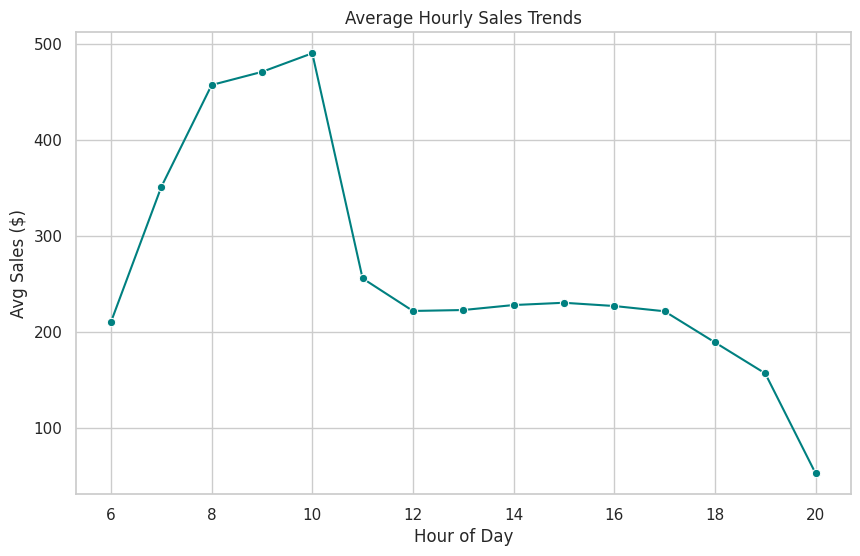

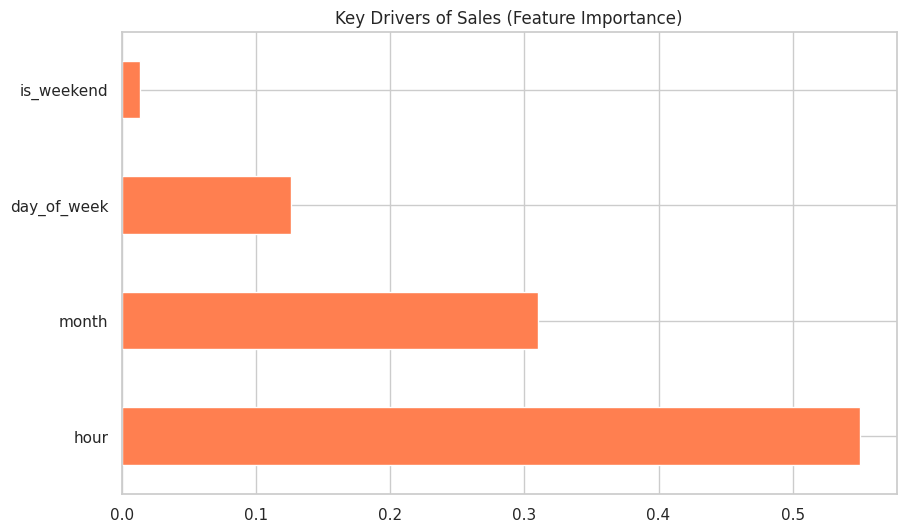

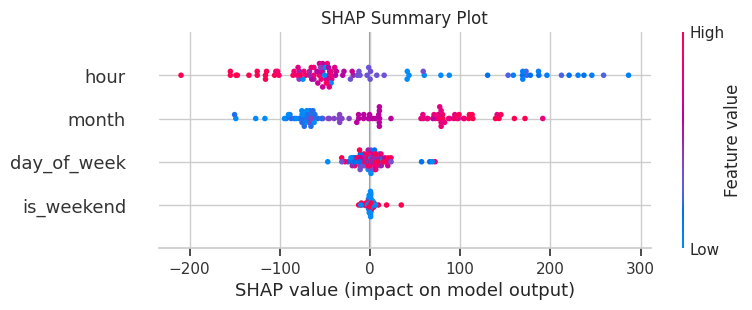

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# Set visualization style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

def run_full_analysis(file_path):
    print("--- 1. Data Loading & Cleaning ---")
    df = pd.read_excel(file_path)
    df['transaction_date'] = pd.to_datetime(df['transaction_date'])
    df['transaction_time'] = pd.to_datetime(df['transaction_time'], format='%H:%M:%S').dt.time

    print("--- 2. Feature Engineering ---")
    df['hour'] = df['transaction_time'].apply(lambda x: x.hour)
    df['day_of_week'] = df['transaction_date'].dt.dayofweek
    df['day_name'] = df['transaction_date'].dt.day_name()
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    df['month'] = df['transaction_date'].dt.month
    df['total_revenue'] = df['transaction_qty'] * df['unit_price']

    # Aggregate to hourly sales for modelling
    hourly_sales = df.groupby(['transaction_date', 'hour', 'day_of_week', 'is_weekend', 'month'])['total_revenue'].sum().reset_index()

    print("--- 3. Insight Extraction ---")
    total_rev = df['total_revenue'].sum()
    avg_trans = df['total_revenue'].mean()
    afternoon_sales = df[df['hour'].isin([14, 15, 16])]['total_revenue'].sum()
    morning_peak_sales = df[df['hour'].isin([7, 8, 9])]['total_revenue'].sum()
    slump_ratio = afternoon_sales / morning_peak_sales

    print(f"Total Revenue: ${total_rev:,.2f}")
    print(f"Avg Transaction: ${avg_trans:.2f}")
    print(f"Afternoon Slump Ratio: {slump_ratio:.2%}")

    print("--- 4. Modelling (Random Forest) ---")
    X = hourly_sales[['hour', 'day_of_week', 'is_weekend', 'month']]
    y = hourly_sales['total_revenue']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"R-Squared Score: {r2_score(y_test, y_pred):.4f}")
    print(f"Mean Absolute Error: ${mean_absolute_error(y_test, y_pred):.2f}")

    print("--- 5. Visualizations ---")
    # Hourly Trends
    plt.figure()
    avg_hourly = hourly_sales.groupby('hour')['total_revenue'].mean()
    sns.lineplot(x=avg_hourly.index, y=avg_hourly.values, marker='o', color='teal')
    plt.title('Average Hourly Sales Trends')
    plt.xlabel('Hour of Day')
    plt.ylabel('Avg Sales ($)')
    plt.savefig('hourly_trends.png')

    # Feature Importance
    plt.figure()
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(10).plot(kind='barh', color='coral')
    plt.title('Key Drivers of Sales (Feature Importance)')
    plt.savefig('feature_importance.png')

    print("--- 6. SHAP Analysis ---")
    X_test_subset = X_test.sample(100, random_state=42)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_subset)

    plt.figure()
    shap.summary_plot(shap_values, X_test_subset, show=False)
    plt.title('SHAP Summary Plot')
    plt.savefig('shap_summary.png')

    print("Analysis Complete. Visualizations saved as PNG files.")

if __name__ == "__main__":
    run_full_analysis('https://raw.githubusercontent.com/jameskch-collab/LLM_Project_Assignment/main/Coffee%20Shop%20Sales.xlsx')